# Hybrid Images

## Introduction
Hybrid images was proposed in the SIGGRAPH 2006 [paper](https://www.researchgate.net/publication/220184425_Hybrid_images) by Oliva, Torralba, and Schyns. [Here](http://olivalab.mit.edu/hybridimage.htm) is the webpage of their work.

Hybrid images are static images that change in interpretation as a function of the viewing distance. The basic idea is that high frequency tends to dominate perception when it is available, but, at a distance, only the low frequency (smooth) part of the signal can be seen. By blending the high frequency portion of one image with the low-frequency portion of another, you get a hybrid image that leads to different interpretations at different distances.

<img src="hybrid.jpg" style="zoom:100%" />

Low-frequency parts of the image can be understood as "contours", such as the shape of the face. "high attached microdermabrasion" 微晶磨皮

The high-frequency parts of the image can be understood as "details", such as wrinkles and spots on the face.

Therefore, we often say that the low-frequency part of the image is obtained after the image is blurred, and the image is sharpened to make the high-frequency information of the image more.

## Basic steps

The overall idea of the implementation is simple-superimpose a picture with only low-frequency information and an image with only high-frequency information. Specific steps are as follows:

1. Prepare low-frequency filters (usually Gaussian blur filter).
2. Convolution of each dimension of the first image with Gaussian filter.
3. Convolution of each dimension of the second image with Gaussian filter, and subtract the filtered image from the original image to obtain the high-frequency image. ! NOTE that the Gaussian filter in this step may have different standard deviation from the above one. You need to try different values to produce satisfatory results.
4. Add the two processed images to get a hybrid image.

## Implementation details

### 1. Read a pair of images and alignment

Read a pair of images. You can use the the given images for test, but for submission, you have to use your own images. The image pair should be well aligned for satisfatory results. You need to mannualy select two points on each image and calculate the rotation and scaling parameters.

<img src="data/cat.bmp" style="zoom:60%" /> <img src="data/dog.bmp" style="zoom:60%" />

For example, the above cat and dog are not aligned. We need to rotate and scale the dog image to align with the cat. We select the centers of the two eyes on the dog image, then we can caculate the rotation angle and the scaling factor.

This method exploys two points on each image. You need to think of appropriate steps to do the alignment. The following steps are just one possible way:

1. Select two points A1 and A2 on image A for alignement; and selcet two points B1 and B2 on image B;

2. Translate image B so that B1 is aligned with A1;

3. Rotate image B to make the line B1B2 have the same direction with line A1A2;

4. Scale image B, so that the distance between B1 and B2 is equal to the distance between A1 and A2;

5. Crop the images to make the two image have the same size.


Please write your code below to align your image pair. Note that, you can use OpenCV functions for rotation and scaling.

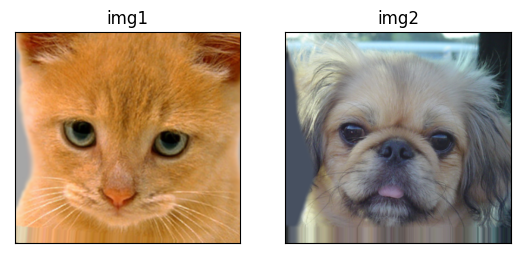

In [2]:
import cv2
import numpy as np
import math
import matplotlib.pyplot as plt


def img_rotate(src, angel):
    """逆时针旋转图像任意角度

    Args:
        src (np.array): [原始图像]
        angel (int): [逆时针旋转的角度]

    Returns:
        [array]: [旋转后的图像]
    """
    h,w = src.shape[:2]
    center = (w//2, h//2)
    M = cv2.getRotationMatrix2D(center, angel, 1.0)
    # 调整旋转后的图像长宽
    rotated_h = int((w * np.abs(M[0,1]) + (h * np.abs(M[0,0]))))
    rotated_w = int((h * np.abs(M[0,1]) + (w * np.abs(M[0,0]))))
    M[0,2] += (rotated_w - w) // 2
    M[1,2] += (rotated_h - h) // 2
    # 旋转图像
    rotated_img = cv2.warpAffine(src, M, (rotated_w,rotated_h))

    return rotated_img

# for example, the two points on the first image are:
# p11 = [100, 200]
# p12 = [200, 200]

p11 = [130, 194]
p12 = [279, 194]


# and the corresponding two points on the second image are:
# p21 = [120, 190]
# p22 = [190, 220]

p21 = [122, 187]
p22 = [284, 201]

# TODO: write your own code to calculate the rotation and scaling parameter
cat = cv2.imread('./data/cat.bmp')   #shape: (361, 410, 3)
dog = cv2.imread('./data/dog.bmp')   #shape: (361, 410, 3)
# print(cat.shape, dog.shape)
h1, w1, c1 = cat.shape
h2, w2, c2 = dog.shape
cx1 = (p11[0] + p12[0]) / 2  #第一张图像两个点的横坐标之和/2
cy1 = (p11[1] + p12[1]) / 2  #第一张图像两个点的纵坐标之和/2
cx2 = (p21[0] + p22[0]) / 2  
cy2 = (p21[1] + p22[1]) / 2
# 注:x轴是横向的,y轴是纵向的
tx = np.round((w1 / 2 - cx1) * 2)  #获得两点中心的横坐标与图像中心的差,然后乘2
if tx > 0:  #大于0,说明图像中心的横坐标位于两点中心的右方.则前面需要填充
    img1 = np.pad(cat, ((0,0),(int(tx), 0),(0,0)),'edge')
else:       #小于0,说明图像中心的横坐标位于两点中心的前方,则后面需要填充
    img1 = np.pad(cat, ((0,0),(0, int(-tx)),(0,0)),'edge')
ty = np.round((h1 / 2 - cy1) * 2)  #获得两点中心的纵坐标与图像中心的差,然后乘2
if ty > 0: #大于0,说明图像中心的纵坐标位于两点中心的下方,则上面需要填充
    img1 = np.pad(img1, ((int(ty),0),(0,0),(0,0)),'edge')
else:      #小于0,说明图像中心的纵坐标位于两点中心的上方,则下面需要填充
    img1 = np.pad(img1, ((0,int(-ty)),(0,0),(0,0)),'edge')
tx = np.round((w2 / 2 - cx2) * 2)
if tx > 0:
    img2 = np.pad(dog, ((0,0),(int(tx), 0),(0,0)),'edge')
else:
    img2 = np.pad(dog, ((0,0),(0, int(-tx)),(0,0)),'edge')
ty = np.round((h2 / 2 - cy2) * 2)
if ty > 0:
    img2 = np.pad(img2, ((int(ty),0),(0,0),(0,0)),'edge')
else:
    img2 = np.pad(img2, ((0,int(-ty)),(0,0),(0,0)),'edge')


# TODO: apply the rotation and scaling on the image
#scale
len1 = np.sqrt((p12[0] - p11[0]) ** 2 + (p12[1] - p11[1]) ** 2)
len2 = np.sqrt((p22[0] - p21[0]) ** 2 + (p22[1] - p21[1]) ** 2)
dscale = len2 / len1
if dscale < 1:
    img1 = cv2.resize(img1, None, fx=dscale, fy=dscale, interpolation=cv2.INTER_LINEAR)
else:
    img2 = cv2.resize(img2, (380,356),fx = 1./dscale, fy = 1./dscale ,interpolation=cv2.INTER_LINEAR)
#rotation
theta1 = math.atan2(-(p12[1] - p11[1]), p12[0] - p11[0])
theta2 = math.atan2(-(p22[1] - p21[1]), p22[0] - p21[0])
dtheda = theta2 - theta1
img1 = img_rotate(img1, dtheda * 180 / np.pi)
#crop
h1, w1, _ = img1.shape
h2, w2, _ = img2.shape
minw = min(w1, w2)
brd = (max(w1, w2) - minw) / 2

if minw == w1: #crop img2
    img2 = img2[:,int(np.ceil(brd)+1):(w2-int(np.floor(brd))),:]
    tx = tx - np.ceil(brd)
else: #crop img1
    img1 = img1[:, int(np.ceil(brd)+1):(w1-int(np.floor(brd))),:]
    tx = tx + np.ceil(brd)
minh = min(h1, h2)
brd = (max(h1, h2) - minh) / 2
if minh == h1: #crop img2
    img2 = img2[int(np.ceil(brd)+1):(h2-int(np.floor(brd))),:,:]
    ty = ty - np.ceil(brd)
else:
    img1 = img1[int(np.ceil(brd)+1):(h1-int(np.floor(brd))),:,:]
    ty = ty + np.ceil(brd)


img1 = cv2.resize(img1, (img2.shape[1],img2.shape[0]), interpolation = cv2.INTER_AREA)
# print(img1.shape,img2.shape)

plt.subplot(121)
plt.xticks([]),plt.yticks([])
plt.title('img1')
plt.imshow(img1[:,:,::-1])
plt.subplot(122)
plt.xticks([]),plt.yticks([])
plt.title('img2')
plt.imshow(img2[:,:,::-1])
plt.show()
# cv2.imshow('img1', img1)
# cv2.imshow('img2', img2)

# while(cv2.waitKey(0) == 27):
#     cv2.destroyAllWindows()
#     break

### 2. Make Gaussian filters
You need to make your own Gaussian filters even the OpenCV has provided you with some easy to use functions as follows.

In [ ]:
# import cv2
# out = cv2.GaussianBlur(in, 0, 4)

When you make your own Gaussian filter, you have to specify the filter size (usually odd number) and the standard deviation. In OpenCV, if the kernerl size is given but the standard deviation $\sigma$ is not given, then $\sigma$ can be determined according to:
$$
\sigma = 0.3*((ksize-1)*0.5 - 1) + 0.8
$$
If the $\sigma$ is given but the kernel size is not given, then the kernel size can be se to $6\sigma$ or $8\sigma$ (usually an odd number), as we have discussed in the lecture that $[-3\sigma, 3\sigma]$ of a Gaussian function captures 99.7% of the energy.

This [blog](https://www.cnblogs.com/shine-lee/p/9671253.html) gives a detailed discussion on the selection of kernel size and $\sigma$.

Please finish the following function to generate your Gaussian filter:

**NOTE!!!! The sum of the kernel weights should be 1.**

In [3]:
def MakeGaussianFilter(size=5,sigma=2.5):
    filter = np.zeros((size,size), dtype=np.float64)
    p = size // 2
    for x in range(-p, -p + size):
        for y in range(-p, -p + size):
            filter[y+p, x+p] = np.exp(-(x**2+y**2)/(2*(sigma**2)))
    filter /= (sigma * np.sqrt(2 * np.pi))
    filter /= filter.sum()
    return filter

### 3. Padding your images

We will use zero-padding to keep the filtered image having the same size with the input image. The padding should be half size of your filter kernel. For example, the following figure shows a 3x3 filter and a 5x5 input image. With padding on the top, bottom, left and right with 1 row/column zeros (note, the filter size 3 divided by 2, therefore the padding is 1, 3//2=1), the filtered image has the same size of the input (5x5). If your filter size is, for example 21x21, then the padding should be 10 rows/columns of zeros on each of the 4 boarders.

<img src="zero-padding.png" style="zoom:60%" />

In [4]:
def Padding(im, pad):
    h, w, c = im.shape
    out = np.zeros((h + 2*pad, w + 2*pad, c),dtype=np.float64)
    out[pad:pad+h, pad:pad+w] = im.copy().astype(np.float64)
    return out

### 4. Convolution

Write your own code for the 2D convolution function. Use a filter to convolve on an image (RGB image).

For just this assignment, you are forbidden from using any Numpy, Scipy, OpenCV, or other preimplemented functions for filtering. You are allowed to use basic matrix operations like np.shape, np.zeros, and np.transpose. This limitation will be lifted in future assignments, but for now, you should use for loops or Numpy vectorization to apply a kernel to each pixel in the image.

In [5]:
def Convolution2D(im, filter):
    h, w, c = im.shape
    size = filter.shape[0]
    p = filter.shape[0] // 2
    img = Padding(im, p)
    tmp = img.copy()
    for y in range(h):
        for x in range(w):
            for ci in range(c):
                img[p+y,p+x,ci] = np.sum(filter * tmp[y:y+size,x:x+size,ci])
    img = img[p:p+h,p:p+w].astype(np.uint8)
    return img

### 5. Filter your images and make hybrid image

Make a Gaussian filter to convolve on image A, get the blured image A'. Make another Gaussian filter to convolve on image B, and substract the result from the original B, get the detail image B'. Add A' and B' to get the hybrid image.

NOTE! You may have to try different values for the standard deviation in Gaussian filters to get satifactory results.

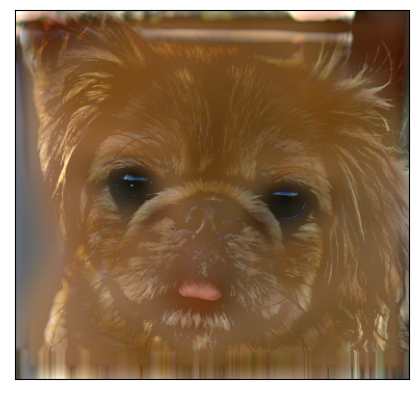

In [6]:
# TODO:
import numpy as np
filter = MakeGaussianFilter(size=31,sigma=25)
img1_G = Convolution2D(img1, filter)
filter1 = MakeGaussianFilter(size=31,sigma=15)
img2_G = Convolution2D(img2, filter1)

img1_G = np.clip(img1_G, 0, 255)
img2_G = np.clip(img2_G, 0, 255)

#对img2做Laplacian of Gaussian
img2_G_ = cv2.subtract(img2, img2_G)

#将img1_G与img2_L相加
hybrid_img = cv2.addWeighted(img1_G, 0.6, img2_G_,1.5, 0)


plt.xticks([]),plt.yticks([])
plt.imshow(hybrid_img[:,:,::-1])
plt.show()


# cv2.imshow('img1_G', img1_G)
# cv2.imshow('img2_G', img2_G)
# cv2.imshow('img2_G_',img2_G_)
# cv2.imshow('hybrid_img', hybrid_img)
# while(cv2.waitKey(0) == 27):
#     cv2.destroyAllWindows()
#     break

### 6. Make Gaussian pyramid to show your hybrid image

Use Gaussian filter to build up a Gaussian pyramid. The lower level image in the pyramid should exhibit high frequency information (details); while the higher level image in the pyramid should exhibit low frequency information.

<img src="hybrid_image_scales.jpg" style="zoom:60%" />

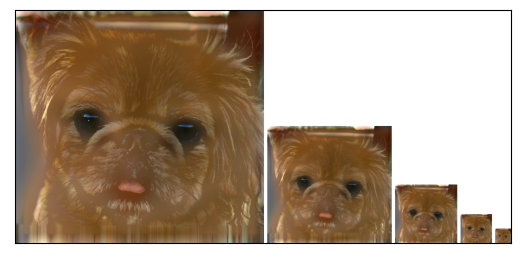

In [15]:
# TODO:
import cv2
import numpy as np
import matplotlib.pyplot as plt

lower = hybrid_img.copy()

scales = 5
scales_factor = 0.5
padding = 5
original_h, original_w, c = hybrid_img.shape
output = lower[:]
cur_image = lower[:]

for i in range(1, scales):
    output = np.concatenate((output, np.ones((original_h, padding, c), dtype=np.uint8) * 255), axis=1)
    cur_image = cv2.resize(cur_image, None, fx=scales_factor, fy=scales_factor, interpolation=cv2.INTER_LINEAR)
    tmp = np.concatenate((np.ones((original_h - cur_image.shape[0], cur_image.shape[1], c), dtype=np.uint8) * 255,cur_image), axis=0)
    output = np.concatenate((output, tmp), axis = 1)
    # cv2.imshow(str(i), tmp)

plt.imshow(output[:,:,::-1])
plt.xticks([]),plt.yticks([])
plt.show()
# cv2.imshow('output', output)
# while(cv2.waitKey(0) == 27):
#     cv2.destroyAllWindows()
#     break

## References

0. The origianl authors' project page. http://olivalab.mit.edu/hybridimage.htm
1. A Tutorial. https://jeremykun.com/2014/09/29/hybrid-images/
2. Chinese blog，matlab code, with alignment。 https://blog.csdn.net/breeze_blows/article/details/102962559
3. Matlab code. https://github.com/coldmanck/Image-Filtering-and-Hybrid-Images
4. Soton University. http://comp3204.ecs.soton.ac.uk/cw/coursework2.html
5. Brown University. http://cs.brown.edu/courses/cs143/2011/ and the project http://cs.brown.edu/courses/cs143/2011/proj1/
6. Python implementation with GUI. https://github.com/ReynoldZhao/Hybrid_Images
7. George Washington University, student's homework. https://blog.csdn.net/Sengo_GWU/article/details/79336511
8. Georgia Institute of Technology, student's homework. https://github.com/all4win/Computer_Vision_Proj1_Image_Filtering_and_Hybrid_Images and https://www.cc.gatech.edu/classes/AY2016/cs4476_fall/results/proj1/html/jwei74/index.html
9. 电子科大的学生作业. https://blog.csdn.net/sinat_41942180/article/details/107972994
10. 比较详细的中文博客文章，Matlab代码. https://blog.csdn.net/weixin_45901986/article/details/104823057
11. 英国南安普顿大学的博士研究生的知乎文章. https://zhuanlan.zhihu.com/p/106619097
12. Washington University in St. Louis. Student's project. https://sites.google.com/site/cse559acomputervisionprojects/home/project-1-hybrid-images